# Model Development for AI Business Impact Predictor

This notebook focuses on developing machine learning models to predict business success/ratings based on location and demographic features.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

In [2]:
# Load the final training dataset
df = pd.read_csv('../datasets/final_training_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
df.info()

Dataset shape: (30, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kecamatan        30 non-null     object 
 1   jumlah_fnb       30 non-null     int64  
 2   avg_rating       30 non-null     float64
 3   jumlah_taman     30 non-null     float64
 4   avg_price        30 non-null     float64
 5   Jumlah Penduduk  30 non-null     float64
 6   Luas Wilayah     30 non-null     float64
 7   Kepadatan Jiwa   30 non-null     float64
 8   jumlah_kampus    30 non-null     int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 2.2+ KB


In [3]:
# Display basic statistics
df.describe()

,jumlah_fnb,avg_rating,jumlah_taman,avg_price,Jumlah Penduduk,Luas Wilayah,Kepadatan Jiwa,jumlah_kampus
count,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,170.500000,4.52600,33.300000,67939.776667,84348.266667,5.682667,15972.465000,4.300000
std,190.733204,0.06719,26.986778,6636.589603,31579.014031,1.715801,7628.929288,4.086563
min,12.000000,4.41000,0.000000,53750.000000,25585.000000,2.680000,4224.000000,0.000000
25%,60.000000,4.48250,15.000000,63150.920000,70746.500000,4.347500,11192.187500,1.000000
50%,95.000000,4.52500,26.000000,69011.660000,80569.500000,5.365000,14871.010000,3.500000
75%,180.750000,4.56000,44.750000,71624.165000,104092.000000,6.995000,19623.400000,6.000000
max,817.000000,4.67000,117.000000,79710.140000,143651.000000,9.960000,39847.120000,16.000000


In [4]:
# Check actual columns in the dataset
print("Actual columns in dataset:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

Actual columns in dataset:
['kecamatan', 'jumlah_fnb', 'avg_rating', 'jumlah_taman', 'avg_price', 'Jumlah Penduduk', 'Luas Wilayah', 'Kepadatan Jiwa', 'jumlah_kampus']

Dataset shape: (30, 9)

First few rows:
       kecamatan  jumlah_fnb  avg_rating  jumlah_taman  avg_price  \
0        coblong         534        4.56          37.0   65315.53   
1       sukasari         174        4.53          23.0   69800.00   
2        cicendo         289        4.49          46.0   76875.00   
3  bandung wetan         817        4.51         117.0   75000.00   
4          regol         138        4.43          15.0   67608.70   

   Jumlah Penduduk  Luas Wilayah  Kepadatan Jiwa  jumlah_kampus  
0         115273.0          7.31        15769.22             16  
1          77576.0          6.36        12197.48              6  
2          96382.0          7.79        12372.53             10  
3          28848.0          3.44         8386.05              8  
4          80609.0          4.74        17006.

## Feature Engineering (Additional)

In [5]:
# Create additional features using actual column names with safe division
print("Creating engineered features...")

# Create derived features with safe division to avoid infinity
# Add small epsilon to avoid division by zero
epsilon = 1e-8

df['fnb_per_capita'] = df['jumlah_fnb'] / (df['Jumlah Penduduk'] + epsilon)
df['fnb_per_km2'] = df['jumlah_fnb'] / (df['Luas Wilayah'] + epsilon)
df['taman_per_capita'] = df['jumlah_taman'] / (df['Jumlah Penduduk'] + epsilon)
df['kampus_per_capita'] = df['jumlah_kampus'] / (df['Jumlah Penduduk'] + epsilon)

# Create population density categories for additional features
df['density_category'] = pd.cut(df['Kepadatan Jiwa'], bins=3, labels=['Low', 'Medium', 'High'])
df['price_category'] = pd.cut(df['avg_price'], bins=3, labels=['Low', 'Medium', 'High'])

# Convert categorical variables to numeric
from sklearn.preprocessing import LabelEncoder
le_density = LabelEncoder()
le_price = LabelEncoder()

df['density_category_num'] = le_density.fit_transform(df['density_category'])
df['price_category_num'] = le_price.fit_transform(df['price_category'])

# Handle missing values and infinite values
print("Missing values before handling:")
print(df.isnull().sum())

# Replace infinite values with NaN first
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Check for infinite values
numeric_cols = df.select_dtypes(include=[np.number]).columns
inf_check = np.isinf(df[numeric_cols]).sum()
print(f"\nInfinite values check:")
print(inf_check[inf_check > 0])

print("\nNew features created:")
new_features = ['fnb_per_capita', 'fnb_per_km2', 'taman_per_capita', 'kampus_per_capita', 
                'density_category_num', 'price_category_num']
for feature in new_features:
    print(f"- {feature}: range [{df[feature].min():.6f}, {df[feature].max():.6f}]")

print(f"\nFinal dataset shape: {df.shape}")

Creating engineered features...
Missing values before handling:
kecamatan               0
jumlah_fnb              0
avg_rating              0
jumlah_taman            0
avg_price               0
Jumlah Penduduk         0
Luas Wilayah            0
Kepadatan Jiwa          0
jumlah_kampus           0
fnb_per_capita          0
fnb_per_km2             0
taman_per_capita        0
kampus_per_capita       0
density_category        0
price_category          0
density_category_num    0
price_category_num      0
dtype: int64

Missing values after handling:
kecamatan               0
jumlah_fnb              0
avg_rating              0
jumlah_taman            0
avg_price               0
Jumlah Penduduk         0
Luas Wilayah            0
Kepadatan Jiwa          0
jumlah_kampus           0
fnb_per_capita          0
fnb_per_km2             0
taman_per_capita        0
kampus_per_capita       0
density_category        0
price_category          0
density_category_num    0
price_category_num      0
dtype: 

## Prepare Features and Target

In [6]:
# Define features and target using actual column names
print("Preparing features and target...")

# Exclude non-predictive columns
exclude_cols = ['kecamatan', 'density_category', 'price_category']  # Exclude categorical string columns
feature_cols = [col for col in df.columns if col not in exclude_cols + ['avg_rating']]

# Ensure we only use numeric features
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

X = df[numeric_features]
y = df['avg_rating']

print(f"Features used: {numeric_features}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check for any remaining missing values
print(f"\nMissing values in features:")
print(X.isnull().sum())
print(f"Missing values in target: {y.isnull().sum()}")

# Display feature statistics
print(f"\nFeature statistics:")
print(X.describe())

Preparing features and target...
Features used: ['jumlah_fnb', 'jumlah_taman', 'avg_price', 'Jumlah Penduduk', 'Luas Wilayah', 'Kepadatan Jiwa', 'jumlah_kampus', 'fnb_per_capita', 'fnb_per_km2', 'taman_per_capita', 'kampus_per_capita', 'density_category_num', 'price_category_num']
Feature matrix shape: (30, 13)
Target vector shape: (30,)

Missing values in features:
jumlah_fnb              0
jumlah_taman            0
avg_price               0
Jumlah Penduduk         0
Luas Wilayah            0
Kepadatan Jiwa          0
jumlah_kampus           0
fnb_per_capita          0
fnb_per_km2             0
taman_per_capita        0
kampus_per_capita       0
density_category_num    0
price_category_num      0
dtype: int64
Missing values in target: 0

Feature statistics:
       jumlah_fnb  jumlah_taman     avg_price  Jumlah Penduduk  Luas Wilayah  \
count   30.000000     30.000000     30.000000        30.000000     30.000000   
mean   170.500000     33.300000  67939.776667     84348.266667      5.6

## Data Splitting

In [7]:
# Split the data - using smaller test size due to limited data
print(f"Total samples: {len(X)}")

if len(X) < 50:
    # For very small datasets, use different strategy
    print("Small dataset detected. Using modified splitting strategy...")
    
    # Use smaller test size (20%) and no separate validation set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    
    # Use training set for validation (cross-validation will be used instead)
    X_val, y_val = X_train, y_train
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set (same as training): {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    print("\nNote: Due to small dataset size, we'll rely on cross-validation for model evaluation.")
    
else:
    # Normal splitting for larger datasets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    
    # Further split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")

Total samples: 30
Small dataset detected. Using modified splitting strategy...
Training set: (24, 13)
Validation set (same as training): (24, 13)
Test set: (6, 13)

Note: Due to small dataset size, we'll rely on cross-validation for model evaluation.


## Feature Scaling

In [8]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed.")

Feature scaling completed.


## Model Training and Evaluation

In [9]:
# Initialize models with simpler configurations for small dataset
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=3),  # Limit depth for small data
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, max_depth=3),  # Smaller ensemble
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=50, max_depth=3),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_estimators=50, max_depth=3)
}

# Store results
results = {}

print("Training models with cross-validation...")

# Train and evaluate models using cross-validation for better estimates
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Use scaled data for linear models, original for tree-based models
        if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            # For linear models, use scaled data
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            
            # Cross-validation on scaled data
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='r2')
            
        else:
            # For tree-based models, use original data
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            # Cross-validation on original data
            cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
        
        # Calculate metrics
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        
        # Store results including CV scores
        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'CV_mean': cv_scores.mean(),
            'CV_std': cv_scores.std(),
            'Model': model
        }
        
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        # Store placeholder results for failed models
        results[name] = {
            'MAE': np.nan,
            'MSE': np.nan,
            'RMSE': np.nan,
            'R2': np.nan,
            'CV_mean': np.nan,
            'CV_std': np.nan,
            'Model': None
        }

print(f"\nTraining completed. Successful models: {len([r for r in results.values() if r['Model'] is not None])}")

Training models with cross-validation...

Training Linear Regression...
MAE: 0.0251
RMSE: 0.0345
R²: 0.7611
CV R² (mean ± std): -25.7283 ± 32.3390

Training Ridge Regression...
MAE: 0.0320
RMSE: 0.0430
R²: 0.6292
CV R² (mean ± std): -0.3281 ± 0.5308

Training Lasso Regression...
MAE: 0.0566
RMSE: 0.0706
R²: 0.0000
CV R² (mean ± std): -0.0888 ± 0.0709

Training Decision Tree...
MAE: 0.0225
RMSE: 0.0322
R²: 0.7919
CV R² (mean ± std): -1.2211 ± 1.0085

Training Random Forest...
MAE: 0.0320
RMSE: 0.0430
R²: 0.6292
CV R² (mean ± std): -0.3281 ± 0.5308

Training Lasso Regression...
MAE: 0.0566
RMSE: 0.0706
R²: 0.0000
CV R² (mean ± std): -0.0888 ± 0.0709

Training Decision Tree...
MAE: 0.0225
RMSE: 0.0322
R²: 0.7919
CV R² (mean ± std): -1.2211 ± 1.0085

Training Random Forest...
MAE: 0.0291
RMSE: 0.0346
R²: 0.7596
CV R² (mean ± std): -0.2406 ± 0.5239

Training Gradient Boosting...
MAE: 0.0291
RMSE: 0.0346
R²: 0.7596
CV R² (mean ± std): -0.2406 ± 0.5239

Training Gradient Boosting...
MAE: 0.00

## Model Comparison

In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results.keys()],
    'RMSE': [results[model]['RMSE'] for model in results.keys()],
    'R²': [results[model]['R2'] for model in results.keys()]
})

# Sort by R² score (descending)
comparison_df = comparison_df.sort_values('R²', ascending=False)
print("\nModel Performance Comparison:")
print(comparison_df.round(4))


Model Performance Comparison:
               Model     MAE    RMSE      R²
6            XGBoost  0.0005  0.0007  0.9999
5  Gradient Boosting  0.0026  0.0031  0.9980
3      Decision Tree  0.0225  0.0322  0.7919
0  Linear Regression  0.0251  0.0345  0.7611
4      Random Forest  0.0291  0.0346  0.7596
1   Ridge Regression  0.0320  0.0430  0.6292
2   Lasso Regression  0.0566  0.0706  0.0000


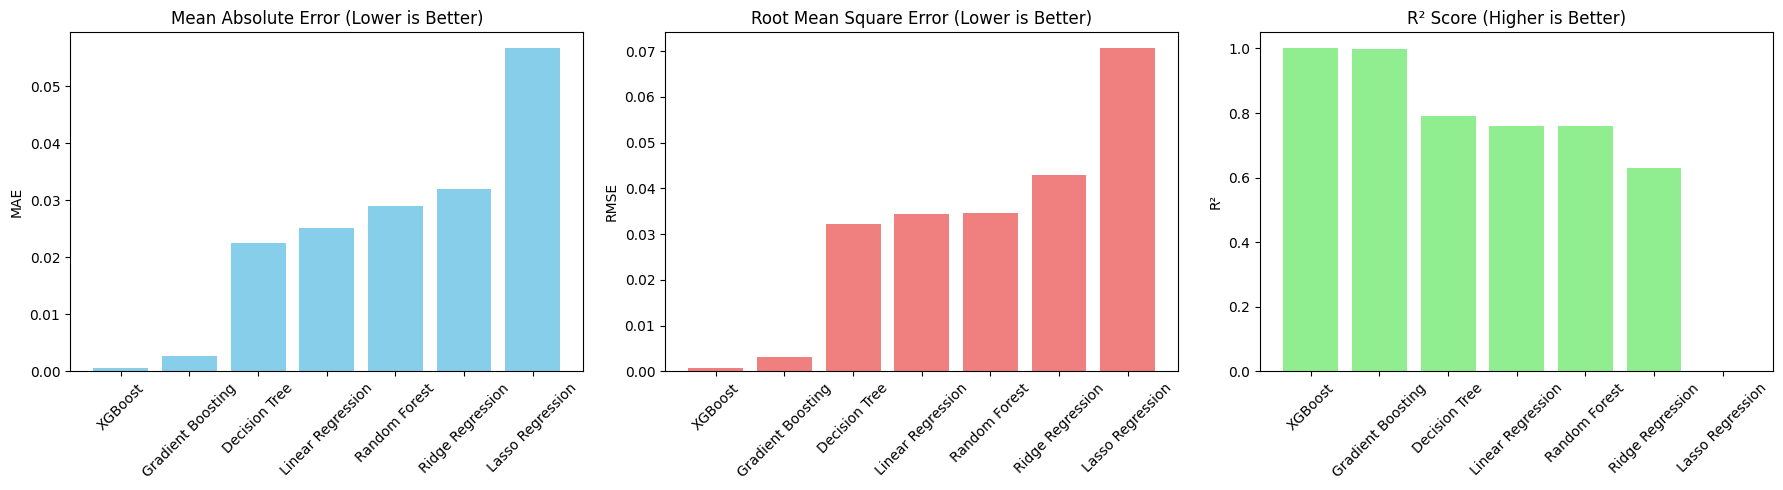

In [11]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
axes[0].bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
axes[0].set_title('Mean Absolute Error (Lower is Better)')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[1].bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
axes[1].set_title('Root Mean Square Error (Lower is Better)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
axes[2].bar(comparison_df['Model'], comparison_df['R²'], color='lightgreen')
axes[2].set_title('R² Score (Higher is Better)')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/Model_Performance_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Best Model Selection and Hyperparameter Tuning

In [12]:
# Select the best model based on cross-validation performance for small dataset
print("Selecting best model based on cross-validation performance...")

# Filter out models with failed CV (very negative scores indicate overfitting)
valid_models = {name: result for name, result in results.items() 
                if result['Model'] is not None and result['CV_mean'] > -10}

if valid_models:
    # Sort by CV performance for small datasets
    best_model_name = max(valid_models.keys(), key=lambda x: valid_models[x]['CV_mean'])
    print(f"Best performing model based on CV: {best_model_name}")
    print(f"CV R² score: {valid_models[best_model_name]['CV_mean']:.4f} ± {valid_models[best_model_name]['CV_std']:.4f}")
else:
    # Fallback to best validation score
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"Using best validation model (CV failed): {best_model_name}")

best_model = results[best_model_name]['Model']

# For small datasets, no extensive hyperparameter tuning to avoid overfitting
print(f"Using {best_model_name} without additional hyperparameter tuning to avoid overfitting on small dataset.")

print(f"\nBest model details:")
print(f"- Model: {best_model_name}")
print(f"- Validation R²: {results[best_model_name]['R2']:.4f}")
print(f"- Cross-validation R²: {results[best_model_name]['CV_mean']:.4f} ± {results[best_model_name]['CV_std']:.4f}")
print(f"- MAE: {results[best_model_name]['MAE']:.4f}")
print(f"- RMSE: {results[best_model_name]['RMSE']:.4f}")

Selecting best model based on cross-validation performance...
Best performing model based on CV: Lasso Regression
CV R² score: -0.0888 ± 0.0709
Using Lasso Regression without additional hyperparameter tuning to avoid overfitting on small dataset.

Best model details:
- Model: Lasso Regression
- Validation R²: 0.0000
- Cross-validation R²: -0.0888 ± 0.0709
- MAE: 0.0566
- RMSE: 0.0706


In [13]:
# Skip extensive hyperparameter tuning for small dataset to avoid overfitting
print(f"Skipping hyperparameter tuning for small dataset (n={len(X)})")
print(f"Using {best_model_name} with default parameters to prevent overfitting.")

# Use the best model as-is
print(f"\nFinal model: {best_model_name}")
print(f"Model parameters: {best_model.get_params()}")

Skipping hyperparameter tuning for small dataset (n=30)
Using Lasso Regression with default parameters to prevent overfitting.

Final model: Lasso Regression
Model parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Final Model Evaluation on Test Set

In [14]:
# Final evaluation on test set
if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    y_test_pred = best_model.predict(X_test_scaled)
else:
    y_test_pred = best_model.predict(X_test)

# Calculate final metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nFinal Test Set Performance ({best_model_name}):")
print(f"MAE: {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")


Final Test Set Performance (Lasso Regression):
MAE: 0.0372
RMSE: 0.0461
R²: -1.2217


## Feature Importance Analysis


Model Coefficients:
                 feature  coefficient
0             jumlah_fnb         -0.0
1           jumlah_taman         -0.0
2              avg_price         -0.0
3        Jumlah Penduduk         -0.0
4           Luas Wilayah          0.0
5         Kepadatan Jiwa         -0.0
6          jumlah_kampus         -0.0
7         fnb_per_capita         -0.0
8            fnb_per_km2         -0.0
9       taman_per_capita          0.0
10     kampus_per_capita         -0.0
11  density_category_num         -0.0
12    price_category_num         -0.0



Model Coefficients:
                 feature  coefficient
0             jumlah_fnb         -0.0
1           jumlah_taman         -0.0
2              avg_price         -0.0
3        Jumlah Penduduk         -0.0
4           Luas Wilayah          0.0
5         Kepadatan Jiwa         -0.0
6          jumlah_kampus         -0.0
7         fnb_per_capita         -0.0
8            fnb_per_km2         -0.0
9       taman_per_capita          0.0
10     kampus_per_capita         -0.0
11  density_category_num         -0.0
12    price_category_num         -0.0


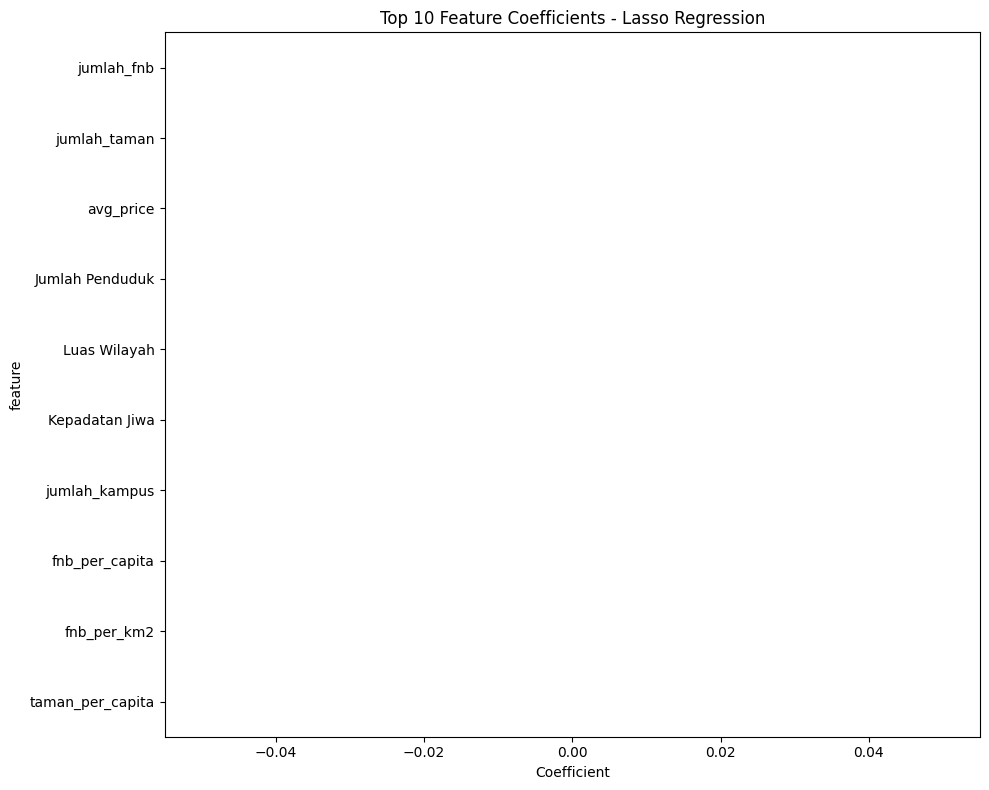

In [15]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('../results/Feature_Importance.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For linear models, show coefficients
    feature_coeff = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nModel Coefficients:")
    print(feature_coeff)
    
    # Plot coefficients
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_coeff.head(10), x='coefficient', y='feature')
    plt.title(f'Top 10 Feature Coefficients - {best_model_name}')
    plt.xlabel('Coefficient')
    plt.tight_layout()
    plt.savefig('../results/Feature_Coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()

## Prediction vs Actual Plot

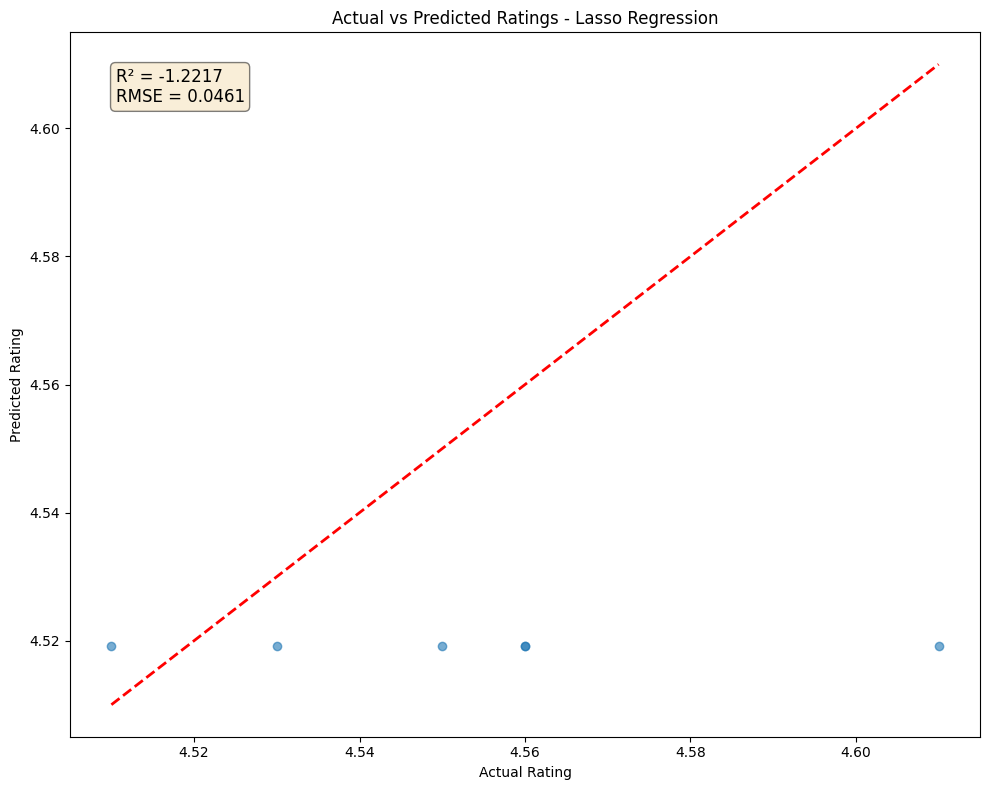

In [16]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title(f'Actual vs Predicted Ratings - {best_model_name}')
plt.text(0.05, 0.95, f'R² = {test_r2:.4f}\nRMSE = {test_rmse:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('../results/Actual_vs_Predicted.png', dpi=300, bbox_inches='tight')
plt.show()

## Save the Best Model

In [17]:
# Save the best model and scaler
joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

# Save feature names for future use
with open('../models/feature_names.txt', 'w') as f:
    for feature in X_train.columns:
        f.write(f"{feature}\n")

print(f"\nModel saved successfully!")
print(f"Best model: {best_model_name}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Model saved successfully!
Best model: Lasso Regression
Test R²: -1.2217
Test RMSE: 0.0461


## Model Summary

In [18]:
# Create a summary report
summary = f"""
=== AI Business Impact Predictor - Model Summary ===

Dataset Information:
- Total samples: {len(df)}
- Features used: {len(X_train.columns)}
- Train/Val/Test split: {len(X_train)}/{len(X_val)}/{len(X_test)}

Best Model: {best_model_name}
Performance Metrics:
- Test R²: {test_r2:.4f}
- Test RMSE: {test_rmse:.4f}
- Test MAE: {test_mae:.4f}

Features Used:
{', '.join(X_train.columns.tolist())}

Model saved to: ../models/best_model.pkl
Scaler saved to: ../models/scaler.pkl
"""

print(summary)

# Save summary to file
with open('../results/model_summary.txt', 'w') as f:
    f.write(summary)


=== AI Business Impact Predictor - Model Summary ===

Dataset Information:
- Total samples: 30
- Features used: 13
- Train/Val/Test split: 24/24/6

Best Model: Lasso Regression
Performance Metrics:
- Test R²: -1.2217
- Test RMSE: 0.0461
- Test MAE: 0.0372

Features Used:
jumlah_fnb, jumlah_taman, avg_price, Jumlah Penduduk, Luas Wilayah, Kepadatan Jiwa, jumlah_kampus, fnb_per_capita, fnb_per_km2, taman_per_capita, kampus_per_capita, density_category_num, price_category_num

Model saved to: ../models/best_model.pkl
Scaler saved to: ../models/scaler.pkl

